# NURBS 2D (1)
### Abordagem usando funções por partes (_piecewise functions_) do _sympy_

In [4]:
import sympy as sp
import pylab as pl
from AuxDisplay import *

sp.init_printing(use_latex=True)

%matplotlib inline

# Definindo funções bases B-Spline

## 2.1 - Funções B-spline

Para um vetor de knots $\Xi$:

\begin{equation}
    \Xi = [\xi_0, \xi_1, ..., \xi_{n+p+1}]
\end{equation}

A i-ésima função de base B-spline de grau p, denotada por $N_{i, p}(x)$, é definida como:

\begin{equation}
N_{i,0}(x) = \left\{
\begin{matrix} 
1 & \mathrm{se} \quad \xi_i \leq x < \xi_{i+1} \\
0 & \mathrm{c.c.} 
\end{matrix}
\right.
\end{equation}

Para $p = 1, 2, ...$, define-se:

\begin{equation}
N_{i,p}(x) = \frac{x - \xi_i}{\xi_{i+p} - \xi_i} N_{i,p-1}(x) + \frac{\xi_{i+p+1} - x}{\xi_{i+p+1} - \xi_{i+1}} N_{i+1,p-1}(x)
\end{equation}

In [5]:
def funcoesBases(n, p, knots, plotar = False):
    '''Cria a n funcoes bases B-Spline de grau p para um vetor de knots'''
    N = [sp.zeros(k, 1) for k in range(len(knots)-1, len(knots)-1-(p+1), -1)]
    
    if plotar: X = pl.linspace(knots[0], knots[-1], 200)
    for p in range(len(N)):
        if plotar: pl.figure('Funções de grau %d'%p)
        for i in range(len(N[p])):
            if p == 0:
                N[p][i] = sp.Piecewise(
                    (0, x < knots[i]),
                    (0, x >= knots[i+1]),
                    ( 1, True )
                )
            else:
                if knots[i+p] != knots[i]:
                    N[p][i] += (x-knots[i])/(knots[i+p]-knots[i]) * N[p-1][i]
                if knots[i+p+1] != knots[i+1]:
                     N[p][i] += (knots[i+p+1]-x)/(knots[i+p+1]-knots[i+1]) * N[p-1][i+1]

            if plotar: pl.plot(X, [N[p][i].subs({x:k}) for k in X], label='N %d,%d'%(i, p))
        if plotar:
            pl.grid()
            pl.title('Funções de grau %d'%p)
            pl.legend(loc='best')
            pl.show()
    return N

### Exemplo 1

\Xi  = [0  0  0  1  2  3  4  4  5  5  5]

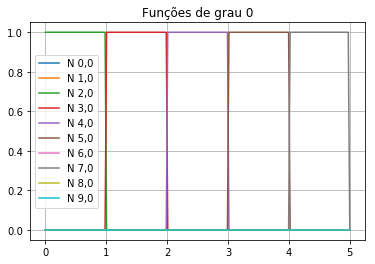

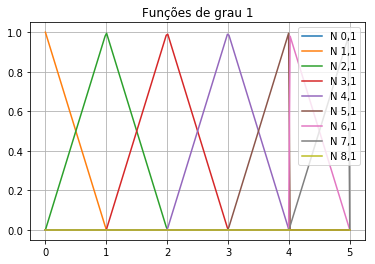

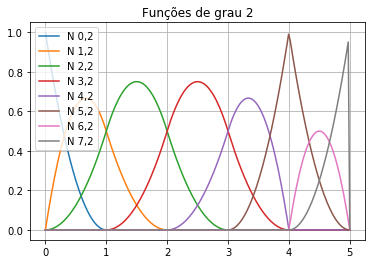

In [6]:
n = 5
p = 2
x = sp.Symbol('x')

knots = [0, 0, 0, 1, 2, 3, 4, 4, 5, 5, 5]
displayEq('\Xi', sp.Array(knots))

N = funcoesBases(n, p, knots, plotar=True)

In [4]:
# display('Funções bases:')

# for pi in range(p+1):
#     for ii in range(len(N[pi])):
        #displayEq('N_{%d\,%d}'%(pi, ii), N[pi][ii].simplify())

### 2.1.1  - Curva B-spline
#### Construindo curva Spline para um conjunto de pontos

Uma curva B-spline de grau $p$ é definida como:

\begin{equation}
    \textbf{S}(x) =\sum_{i=0}^{n} N_{i,p}(x) \textbf{P}_i 
\end{equation}

In [5]:
def curvaSpline2D(pontos, knots, bases):
    '''Plota os vertices de controle e a curva dados os 
        pontos de controle, vetor de knots e funcoes bases'''
    P = pontos
    pl.plot(P[0], P[1], 'k--') # plotar vertices
    pl.plot(P[0], P[1], 'ro')  # plotar pontos

    # N eh matriz coluna
    # cada linha de P eh uma dimensao
    M = sp.Matrix(P) * bases
    Cx, Cy = M[0], M[1]

    X = pl.linspace(knots[0], knots[-1], 200)
    pl.plot([Cx.subs({x:k}) for k in X], [Cy.subs({x:k}) for k in X])

    pl.grid()
    pl.show()

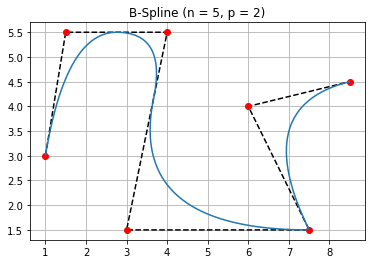

In [6]:
knots = [0, 0, 0, 1, 2, 4, 4, 8, 8, 8]
N = funcoesBases(n, p, knots)

P = [[1.0, 1.5, 4.0, 3.0, 7.5, 6.0, 8.5],
     [3.0, 5.5, 5.5, 1.5, 1.5, 4.0, 4.5]]

pl.title('B-Spline (n = %d, p = %d)'%(n, p))
curvaSpline2D(P, knots, bases=N[-1])

# Definindo funções NURBS

## 2.2 - Funções NURBS

### 2.2.1 - Curva NURBS

#### Exemplo 5

\Xi  = [0  0  0  0  1  1  1  1]

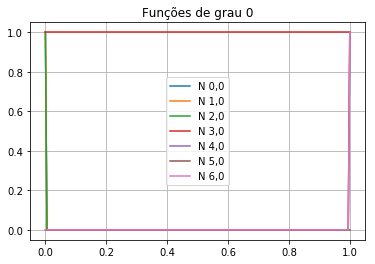

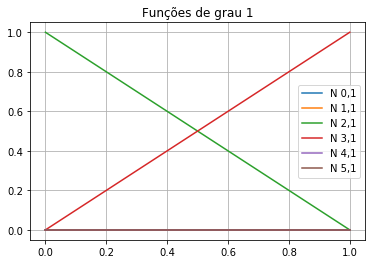

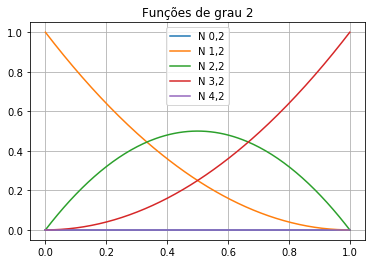

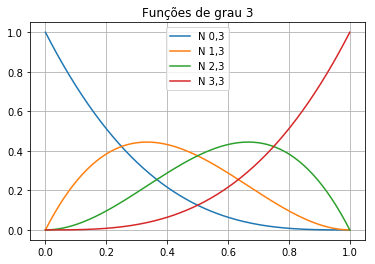

In [7]:
n = 5
p = 3
x = sp.Symbol('x')

# knots = pl.linspace(0, 1, n+p+2)
knots = [0, 0, 0, 0, 1, 1, 1, 1]
displayEq('\Xi', sp.Array(knots))

N = funcoesBases(n, p, knots, plotar=True)

### Atribuindo pesos às bases

In [8]:
W = sp.Array([1, 1/3, 3/4, 1])
displayEq('w', W)

sum_Nw = sum([n * w for n, w in zip(N[p], W)])
R = [(n * w)/sum_Nw for n, w in zip(N[p], W)]
R = sp.Matrix(R)

w  = [1  0.333333333333333  0.75  1]

           ⎧                      nan                        for x > 1 ∨ x < 0
           ⎪                                                                  
           ⎪                           3                                      
R_{0,3}  = ⎨                   -(x - 1)                                       
           ⎪───────────────────────────────────────────────      otherwise    
           ⎪        3         2                2          3                   
           ⎩- 1.25⋅x  + 2.25⋅x  + 1.0⋅x⋅(x - 1)  - (x - 1)                    

           ⎧              nan                for x > 1 ∨ x < 0
           ⎪                                                  
           ⎪        ⎛     2              ⎞                    
R_{1,3}  = ⎨ -1.0⋅x⋅⎝1.0⋅x  - 2.0⋅x + 1.0⎠                    
           ⎪───────────────────────────────      otherwise    
           ⎪      3         2                                 
           ⎩1.25⋅x  - 3.25⋅x  + 2.0⋅x - 1.0                   

           ⎧              nan                for x > 1 ∨ x < 0
           ⎪                                                  
           ⎪              2                                   
R_{2,3}  = ⎨        2.25⋅x ⋅(x - 1)                           
           ⎪───────────────────────────────      otherwise    
           ⎪      3         2                                 
           ⎩1.25⋅x  - 3.25⋅x  + 2.0⋅x - 1.0                   

           ⎧              nan                for x > 1 ∨ x < 0
           ⎪                                                  
           ⎪                  3                               
R_{3,3}  = ⎨            -1.0⋅x                                
           ⎪───────────────────────────────      otherwise    
           ⎪      3         2                                 
           ⎩1.25⋅x  - 3.25⋅x  + 2.0⋅x - 1.0                   

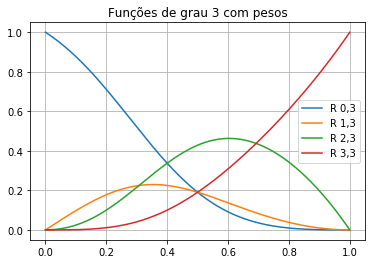

In [9]:
X = pl.linspace(knots[0], knots[-1], 200)
for i, r in enumerate(R):
    displayEq('R_{%d\,%d}'%(i, p), r.simplify())
    pl.plot(X, [r.subs({x:k}) for k in X], label='R %d,%d'%(i, p))
pl.grid()
pl.title('Funções de grau %d com pesos'%p)
pl.legend(loc='best')
pl.show()

### Contruindo curva para um conjunto de pontos

Uma curva NURBS é definida como:

\begin{equation}
    \textbf{C}(x) =\sum_{i=0}^{n} R_{i,p}(x) \textbf{P}_i
\end{equation}

onde:

\begin{equation}
    R_{i,n}(x) = {N_{i,n}(x)w_i \over \sum_{j=0}^k N_{j,n}(x)w_j}
\end{equation}

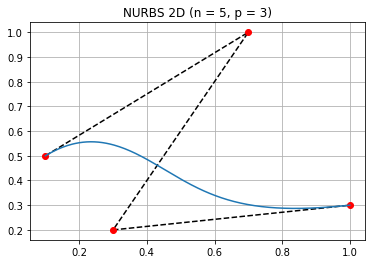

In [10]:
P = [[0.1, 0.7, 0.3, 1.0],
     [0.5, 1.0, 0.2, 0.3]]

# podemos utilizar a mesmo procedimento
pl.title('NURBS 2D (n = %d, p = %d)'%(n, p))
curvaSpline2D(P, knots, bases = R)